In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cellbayesassay as cba
import os.path
import re
import warnings
import attila_utils

In [2]:
TI_conc_fpaths = {
    (2, 4, 5, 6, 7, 8): 'a',
    (3, 9): 'b',
}

In [3]:
fpath = '../../resources/cell-based-assays/data-format-specification.xlsx'
qps_exp_num = pd.read_excel(fpath, sheet_name='Allowed values', usecols=['Experiment', 'QPS experiment number'], index_col='Experiment')
qps_exp_num = qps_exp_num.dropna()
s = pd.concat([pd.Series(v, index=list(k)) for k, v in TI_conc_fpaths.items()])
qps_exp_num['exp_type'] = qps_exp_num['QPS experiment number'].apply(lambda x: s.loc[x])
qps_exp_num['fpath'] = qps_exp_num.exp_type.apply(lambda x: '../../resources/cell-based-assays/test-items3' + x + '.csv')
qps_exp_num

,QPS experiment number,exp_type,fpath
Experiment,,,
Aβ clearance (BV2 cells),3.0,b,../../resources/cell-based-assays/test-items3b...
Aβ release (H4 cells),4.0,a,../../resources/cell-based-assays/test-items3a...
Aβ toxicity (primary neurons),2.0,a,../../resources/cell-based-assays/test-items3a...
LPS neuroinflammation (BV2 cells),6.0,a,../../resources/cell-based-assays/test-items3a...
Neurite outgrowth (primary neurons),7.0,a,../../resources/cell-based-assays/test-items3a...
Tau phoshorylation,5.0,a,../../resources/cell-based-assays/test-items3a...
Trophic factor withdrawal (primary neurons),8.0,a,../../resources/cell-based-assays/test-items3a...


In [4]:
data_fpath = '../../resources/cell-based-assays/data-format-specification_NIA_AB-CO25360-cleaned.xlsx'
data_a, data_b = [cba.get_data(data_fpath, sheet_name='Sheet1', TI_fpath='../../resources/cell-based-assays/test-items3' + et + '.csv') for et in ['a', 'b']]
data = pd.concat([df.loc[df.Experiment.isin(qps_exp_num.loc[qps_exp_num.exp_type == et].index)] for et, df in zip(['a', 'b'], [data_a, data_b])], axis=0)
data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3431.0
1,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3704.0
2,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3536.0
3,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3595.0
4,CO25360,Aβ release (H4 cells),Aβ38,1,1,TI1,Valproic acid,c1,5.000000e-05,-4.30103,3863.0
...,...,...,...,...,...,...,...,...,...,...,...
2749,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,105.0
2750,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,117.0
2751,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,112.0
2752,CO25360,Aβ clearance (BV2 cells),Aβ42 SN,2,1,TI17,C188-9,c3,1.000000e-07,-7.00000,88.0


In [5]:
check_data = True
if check_data:
    testdf = cba.fit_multiple_units(data, unit_list=None, do_fit=False, do_print=False)
    print(testdf)

                                                 study  \
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   CO25360   
                                         TI10  CO25360   
                                         TI11  CO25360   
                                         TI12  CO25360   
                                         TI13  CO25360   
...                                                ...   
        Aβ release (H4 cells)    Aβ42    TI5   CO25360   
                                         TI6   CO25360   
                                         TI7   CO25360   
                                         TI8   CO25360   
                                         TI9   CO25360   

                                                                  exper  \
CO25360 Aβ clearance (BV2 cells) Aβ42 Ly TI1   Aβ clearance (BV2 cells)   
                                         TI10  Aβ clearance (BV2 cells)   
                                         TI11  Aβ clearance (BV2 cells)   
   

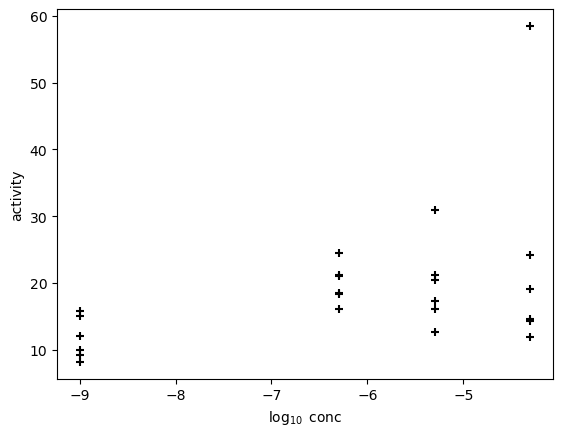

In [6]:
def data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', TI='TI1', data=data):
    fig, ax = plt.subplots()
    data_reshaped = cba.extract_regr_data('CO25360', exper, assay, TI, data, return_data_reshaped=True, accept_multi_batches=True)
    ax = cba.plot_data(ax, data_reshaped)
    return((fig, ax))

fig, ax = data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', TI='TI1')

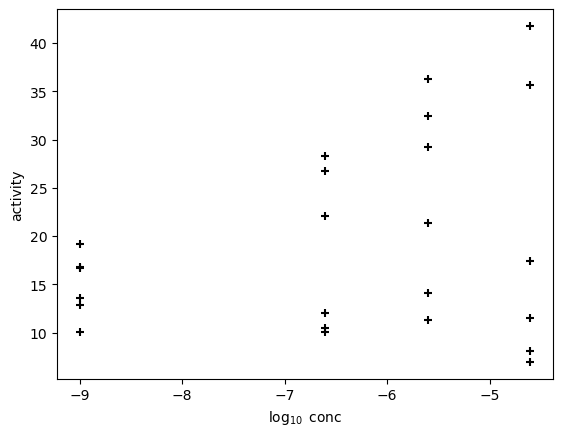

In [7]:
fig, ax = data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 Ly', TI='TI27')

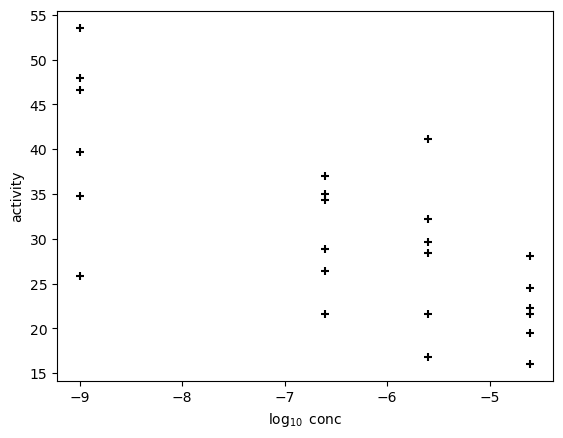

In [8]:
fig, ax = data_plotter(exper='Aβ clearance (BV2 cells)', assay='Aβ42 SN', TI='TI27')

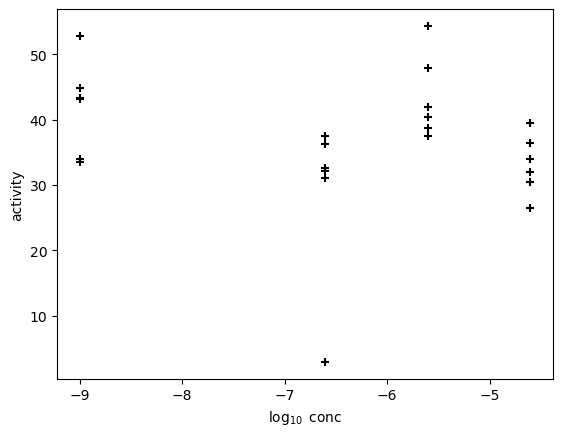

In [9]:
fig, ax = data_plotter(exper='Aβ release (H4 cells)', assay='Aβ38', TI='TI27')

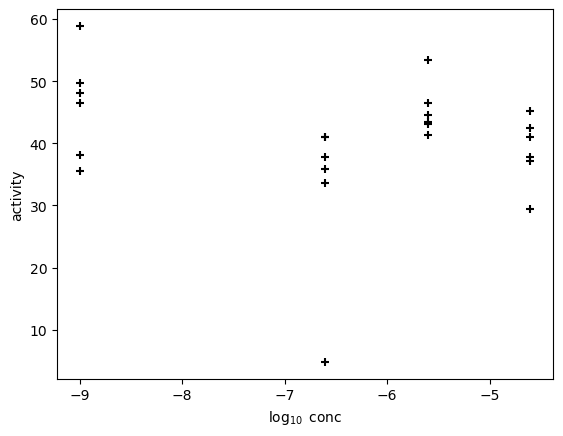

In [10]:
fig, ax = data_plotter(exper='Aβ release (H4 cells)', assay='Aβ40', TI='TI27')

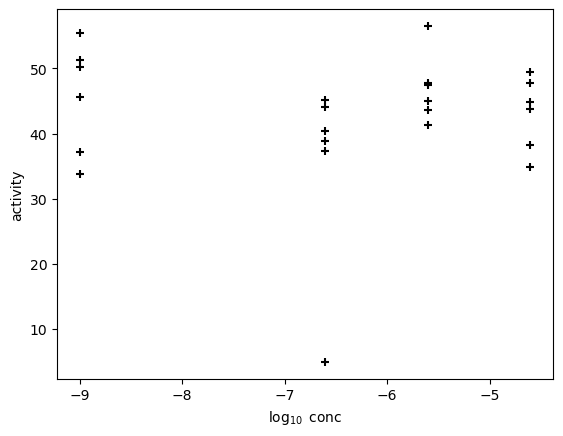

In [11]:
fig, ax = data_plotter(exper='Aβ release (H4 cells)', assay='Aβ42', TI='TI27')

In [12]:
maindir = '../../results/2024-04-29-cell-bayes/'

if not os.path.exists(maindir + 'idatas/fpaths.csv'):
    idatadf = cba.fit_multiple_units(data, unit_list=None, accept_multi_batches=True)
    idatas = idatadf.idata
    fpathdf = cba.idatas_to_netcdf(idatas.dropna(), subdir='idatas/', maindir=maindir)
    print('idatas written to netcdf')
    ## write 3 records for which fit resulted in None instead of arviz.data.inference_data.InferenceData
    #fpath = '../../results/2024-04-21-cell-bayes/fits-resulting-in-None.csv'
    #idatas.loc[idatas.apply(lambda x: not isinstance(x, az.data.inference_data.InferenceData))].to_csv(fpath)
else:
    idatas = cba.idatas_from_netcdf(subdir='idatas/', maindir=maindir)
    print('idatas read from netcdf')

idatas = cba.sort_index_TI(idatas)
idatas


idatas read from netcdf


study    experiment                assay    TI  
CO25360  Aβ clearance (BV2 cells)  Aβ42 Ly  TI1     (posterior, log_likelihood, sample_stats, obse...
                                            TI2     (posterior, log_likelihood, sample_stats, obse...
                                            TI3     (posterior, log_likelihood, sample_stats, obse...
                                            TI4     (posterior, log_likelihood, sample_stats, obse...
                                            TI5     (posterior, log_likelihood, sample_stats, obse...
                                                                          ...                        
         Aβ release (H4 cells)     Aβ42     TI23    (posterior, log_likelihood, sample_stats, obse...
                                            TI24    (posterior, log_likelihood, sample_stats, obse...
                                            TI25    (posterior, log_likelihood, sample_stats, obse...
                                 

In [13]:
plot_sampled_curves = False
fpath_suffix = '' if plot_sampled_curves else '-no-curves'

def assay_plotter(experiment, assay, plot_sampled_curves=plot_sampled_curves, compound_name_title=False):
    unit_list = idatas.loc(axis=0)[:, experiment, assay, :].index.to_numpy()
    fig, ax = cba.plot_multiple_units(unit_list, data, idatas, plot_sampled_curves=plot_sampled_curves, compound_name_title=compound_name_title)
    fig.suptitle(experiment + '\n' + assay)
    return((fig, ax))

for e, a in data[['Experiment', 'Assay']].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1).unique():
    print(e, a)

Aβ release (H4 cells) Aβ38
Aβ release (H4 cells) Aβ40
Aβ release (H4 cells) Aβ42
Aβ clearance (BV2 cells) Aβ42 Ly
Aβ clearance (BV2 cells) Aβ42 SN


['named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-Ly-no-curves.png',
 'named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-Ly-no-curves.pdf']

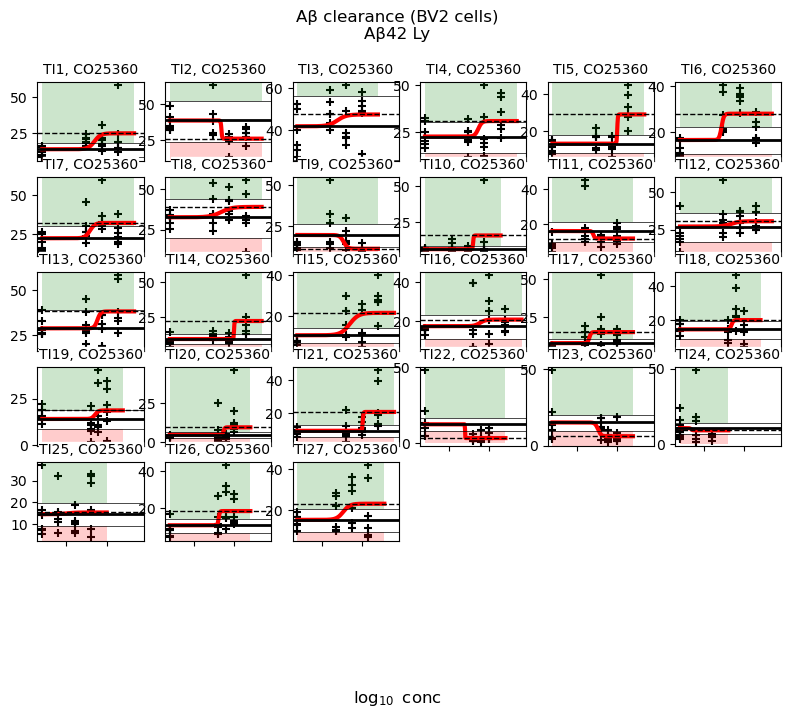

In [14]:
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 Ly'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:267: RuntimeWarning: overflow encountered in exp
  y_sigmoid_1_mean = y_1_mean + (y_0_mean - y_1_mean) / (1 + np.exp(k_mean * (xx - EC_50_mean)))


['named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-SN-no-curves.png',
 'named-figure/fitted-curves-Aβ-clearance-BV2-cells-Aβ42-SN-no-curves.pdf']

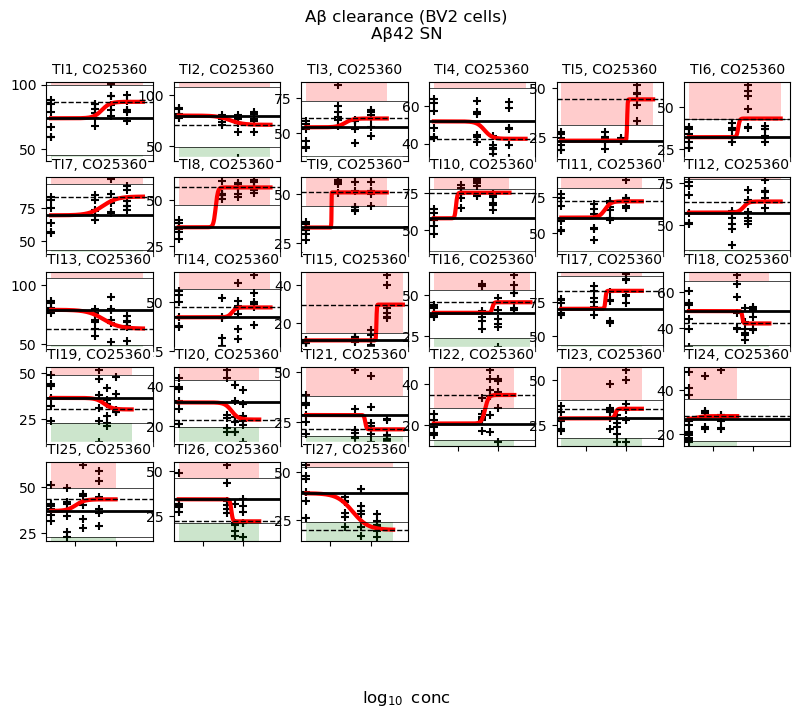

In [15]:
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 SN'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ38-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ38-no-curves.pdf']

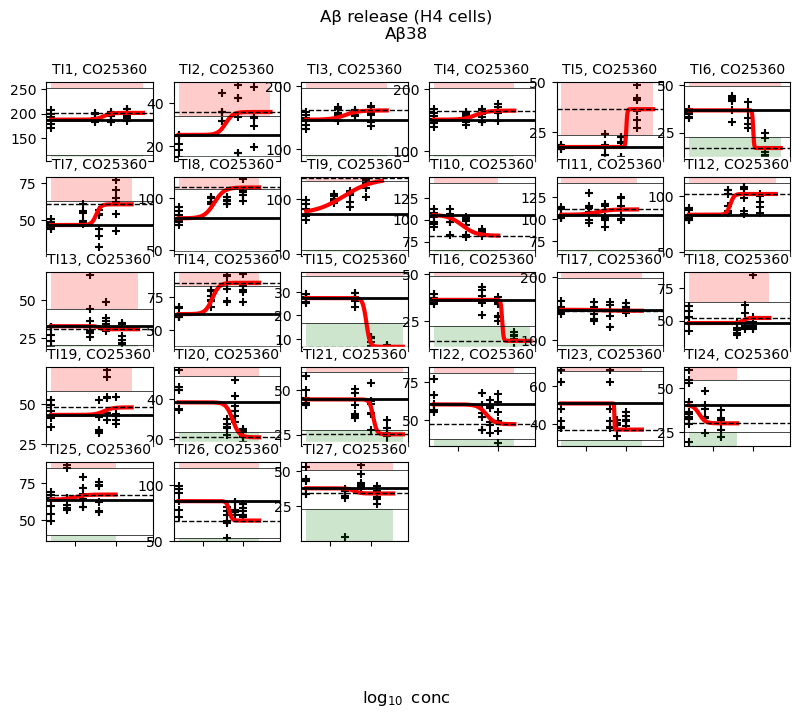

In [16]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ38'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ40-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ40-no-curves.pdf']

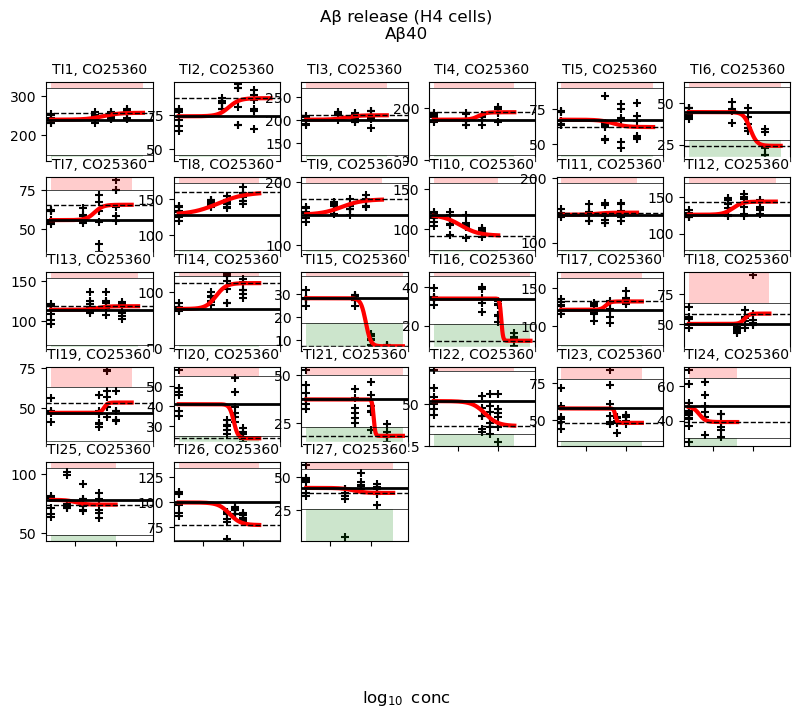

In [17]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ40'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

['named-figure/fitted-curves-Aβ-release-H4-cells-Aβ42-no-curves.png',
 'named-figure/fitted-curves-Aβ-release-H4-cells-Aβ42-no-curves.pdf']

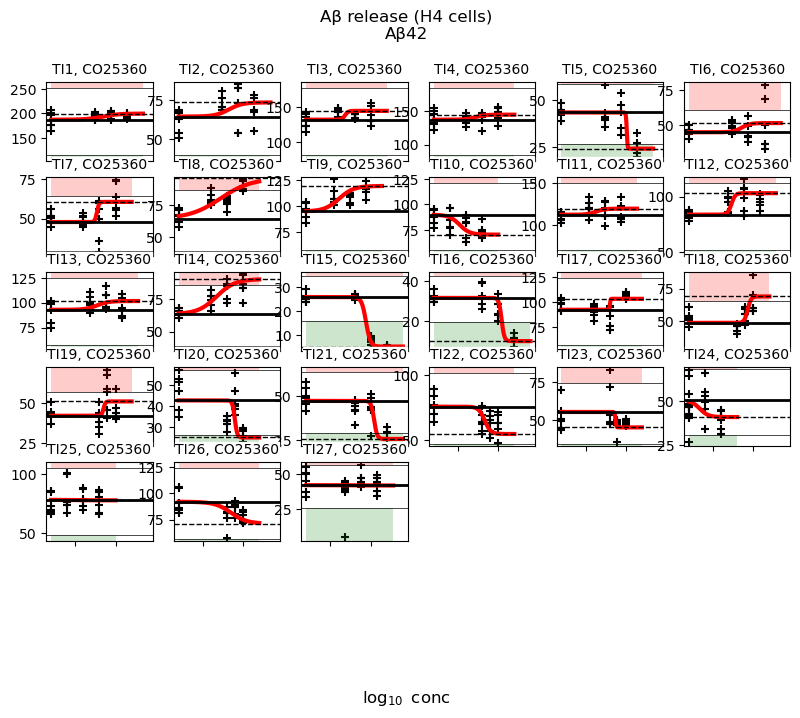

In [18]:
experiment = 'Aβ release (H4 cells)'
assay = 'Aβ42'
fig, ax = assay_plotter(experiment, assay)
attila_utils.savefig(fig, 'fitted-curves-' + re.sub('[ ()]+', '-', experiment + ' ' + assay) + ('' if plot_sampled_curves else '-no-curves'))

In [19]:
%connect_info

{
  "shell_port": 64242,
  "iopub_port": 64243,
  "stdin_port": 64244,
  "control_port": 64246,
  "hb_port": 64245,
  "ip": "127.0.0.1",
  "key": "b0de5479-9ea4519635902cb9180fbd5e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-04-29-cell-bayes/Untitled.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-3b497993-b65d-4a13-9202-f0d82236bafb.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
